In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import matplotlib.cm as cm

In [ ]:
suite2p_path = r'C:\Users\jcbegs\Desktop\Lab_Business\AG_Dean\calcium_imaging\suite2p_tiff\frame_rate_test_new\40fps\suite2p\plane0'
ops =  np.load(suite2p_path + '\ops.npy', allow_pickle=True)
ops = ops.item()
stat = np.load(suite2p_path + '\stat.npy', allow_pickle=True)
F = np.load(suite2p_path + '\F.npy', allow_pickle=True)
Fneu = np.load(suite2p_path + '\Fneu.npy', allow_pickle=True)

In [2]:
def getMaxImg(ops):
    maxImg = ops["max_proj"] # Also "max_proj", "meanImg", "meanImgE"
    mimg = maxImg # Use suite-2p source-code naming
    mimg1 = np.percentile(mimg,1)
    mimg99 = np.percentile(mimg,99)
    mimg = (mimg - mimg1) / (mimg99 - mimg1)
    mimg = np.maximum(0,np.minimum(1,mimg))
    mimg *= 255
    mimg = mimg.astype(np.uint8)
    return mimg

In [3]:
"""Imported from suite2p.gui.utils directly because I cannot yet navigate directories in Python"""
from scipy.ndimage import binary_dilation, binary_fill_holes

def boundary(ypix,xpix):
    """ returns pixels of mask that are on the exterior of the mask """
    ypix = np.expand_dims(ypix.flatten(),axis=1)
    xpix = np.expand_dims(xpix.flatten(),axis=1)
    npix = ypix.shape[0]
    if npix>0:
        msk = np.zeros((np.ptp(ypix)+6, np.ptp(xpix)+6), bool) #OG = np.bool, bool is the new un-depreciated version
        msk[ypix-ypix.min()+3, xpix-xpix.min()+3] = True
        msk = binary_dilation(msk)
        msk = binary_fill_holes(msk)
        k = np.ones((3,3),dtype=int) # for 4-connected
        k = np.zeros((3,3),dtype=int); k[1] = 1; k[:,1] = 1 # for 8-connected
        out = binary_dilation(msk==0, k) & msk

        yext, xext = np.nonzero(out)
        yext, xext = yext+ypix.min()-3, xext+xpix.min()-3
    else:
        yext = np.zeros((0,))
        xext = np.zeros((0,))
    return yext, xext


In [ ]:
Marti2p_path = r'C:\Users\jcbegs\Desktop\Lab_Business\AG_Dean\calcium_imaging\suite2p_tiff\frame_rate_test_new\40fps'

SUITE2P_STRUCTURE = {
    "F": ["suite2p", "plane0", "F.npy"],
    "Fneu": ["suite2p", "plane0", "Fneu.npy"],
    #'spks': ["suite2p", "plane0", "spks.npy"],
    "stat": ["suite2p", "plane0", "stat.npy"],
    "iscell": ["suite2p", "plane0", "iscell.npy"],
    "ops": ["suite2p", "plane0", "iscell.npy"]
}
def load_npy_array(npy_path):
    return np.load(npy_path, allow_pickle=True) 
def load_npy_df(npy_path):
    return pd.DataFrame(np.load(npy_path, allow_pickle=True))
def load_suite2p_output(path, use_iscell=False):
    suite2p_dict = {
        "F": load_npy_array(os.path.join(path, *SUITE2P_STRUCTURE["F"])),
        "Fneu": load_npy_array(os.path.join(path, *SUITE2P_STRUCTURE["Fneu"])),
        "stat": load_npy_df(os.path.join(path, *SUITE2P_STRUCTURE["stat"]))[0].apply(pd.Series)}
    return suite2p_dict


In [4]:
def getStats(stat, frame_shape):
    MIN_SKEW = 1.0 #TODO: define for iscell; also figure exclude noncell
    max_pixel = 200
    max_compact = 1.25
    min_footprint = 0
    max_footprint = 3
    pixel2neuron = np.full((sum(stat.shape), sum(stat.shape)), fill_value=np.nan, dtype=float)
    scatters = dict(x=[], y=[], color=[], text=[])
    min_skew, max_skew = -20000, 20000 #swapoped min/max 20,000 *-1
    nid2idx = {}
    nid2idx_rejected = {}
    print(f"Num cells: {stat.shape[0]}")
    # from suite2p.gui.utils import boundary; recreated the function manually
    for n in range(stat.shape[0]):
        skew = stat[n]['skew']
        # min_skew, max_skew = min(skew, min_skew), max(skew, max_skew)
        npix = stat[n]['npix']
        footprint = stat[n]['footprint']
        compact = stat[n]['compact']
        min_skew, max_skew = min(skew, min_skew), max(skew, max_skew)
        if skew >= MIN_SKEW and npix <= max_pixel and compact <= max_compact and footprint < max_footprint:
            nid2idx[n] = len(scatters["x"]) # Assign new idx
        else:
            nid2idx_rejected[n] = len(scatters["x"])
        ypix = stat[n]['ypix'].flatten() - 1#[~stat[n]['overlap']] - 1
        xpix = stat[n]['xpix'].flatten() - 1#[~stat[n]['overlap']] - 1
        yext, xext = boundary(ypix, xpix)
        scatters['x'] += [xext]
        scatters['y'] += [yext]
        pixel2neuron[xpix, ypix] = n
        scatters["color"].append(skew)
        scatters["text"].append(f"Cell #{n} - Skew: {skew}")
    print("Min/max skew: ", min_skew, max_skew)
    # Normalize colors between 0 and 1
    # color_raw = np.array(scatters["color"])
    # scatters["color"] = (color_raw - min_skew) / (max_skew - min_skew)
    return scatters, nid2idx, nid2idx_rejected, pixel2neuron


In [5]:
def dispPlot(MaxImg, scatters, nid2idx, nid2idx_rejected,
             pixel2neuron, F, Fneu, axs=None):
  if axs is None:
    fig = plt.figure(constrained_layout=True)
    NUM_GRIDS=12
    gs = fig.add_gridspec(NUM_GRIDS, 1)
    ax1 = fig.add_subplot(gs[:NUM_GRIDS-2])
    # ax2 = fig.add_subplot(gs[NUM_GRIDS-2])
    fig.set_size_inches(12,14)
  else:
    ax1 = axs
    ax1.set_xlim(0, MaxImg.shape[0])
    ax1.set_ylim(MaxImg.shape[1], 0)
    # ax2 = None
  ax1.imshow(MaxImg, cmap='gist_gray')
  #fig.update_xaxes(showticklabels=False)
  #fig.update_yaxes(showticklabels=False)
  print("Neurons count:", len(nid2idx))
  norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

  def plotDict(n2d2idx_dict, override_color = None):
    for neuron_id, idx in n2d2idx_dict.items():
      color = override_color if override_color else mapper.to_rgba(scatters['color'][idx])
    # print(f"{idx}: {scatters['x']} - {scatters['y'][idx]}")
      
      sc = ax1.scatter(scatters["x"][idx], scatters['y'][idx], color = color, 
                     marker='.', s=1)
  plotDict(nid2idx)
  plotDict(nid2idx_rejected, 'r')
  ax1.set_title(f"Neurons Used: {len(nid2idx)}/{len(nid2idx)+len(nid2idx_rejected)} detected (orange)") #pontentially change the color of detected/reject from black to red??
  # if ax2 is None:
  #   return
  # nan_fills = np.full(F.shape[1], fill_value = np.nan)
  # neuron_trace_plot = ax2.plot(np.arange(F.shape[1]), nan_fills, color = 'blue')[0]
  # neuron_trace_plot2 = ax2.plot(np.arange(F.shape[1]), nan_fills, color = 'red')[0]
  # text = ax1.text(0,1.06, "No neurons selected")
  # print(f"spks.shape: {spks.dtype}") --> unnecessary since spks are calculated manually

In [6]:
def load(fp):
    stat = np.load(f"{fp}\stat.npy", allow_pickle = True)
    ops = np.load(f"{fp}\ops.npy", allow_pickle = True).item()
    F = np.load(f"{fp}\F.npy", allow_pickle = True)
    Fneu = np.load(f"{fp}\Fneu.npy", allow_pickle = True)
    #iscell / spks also can be repeated in this way
    return stat, ops, F, Fneu
def show_fig_high_fps(fp):
    stat, ops, F, Fneu = load(fp)
    MaxImg = getMaxImg(ops)
    scatters, nid2idx, nid2idx_rejected, pixel2neuron = getStats(stat, (sum(stat.shape), sum(stat.shape)))
    dispPlot(MaxImg, scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu)
def show_fig_low_fps(fp):
    stat, ops, F, Fneu = load(fp)
    MaxImg = getMaxImg(ops)
    scatters, nid2idx, nid2idx_rejected, pixel2neuron = getStats(stat, MaxImg.shape)
    dispPlot(MaxImg, scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu)

In [ ]:
load(r'C:\Users\jcbegs\Desktop\Lab_Business\AG_Dean\calcium_imaging\suite2p_tiff\frame_rate_test_new\2.5fps\suite2p\plane0')
getMaxImg(ops)
scatters, nid2idx, nid2idx_rejected, pixel2neuron = getStats(stat, (sum(stat.shape), sum(stat.shape)))
dispPlot(getMaxImg(ops),scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu)

In [ ]:
scatters, nid2idx, nid2idx_rejected, pixel2neuron = getStats(stat, getMaxImg(ops).shape )
fps_max = dispPlot(getMaxImg(ops),scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu)


Num cells: 680
Min/max skew:  -20000 20000
Neurons count: 318
Frame Rate: 20Hz


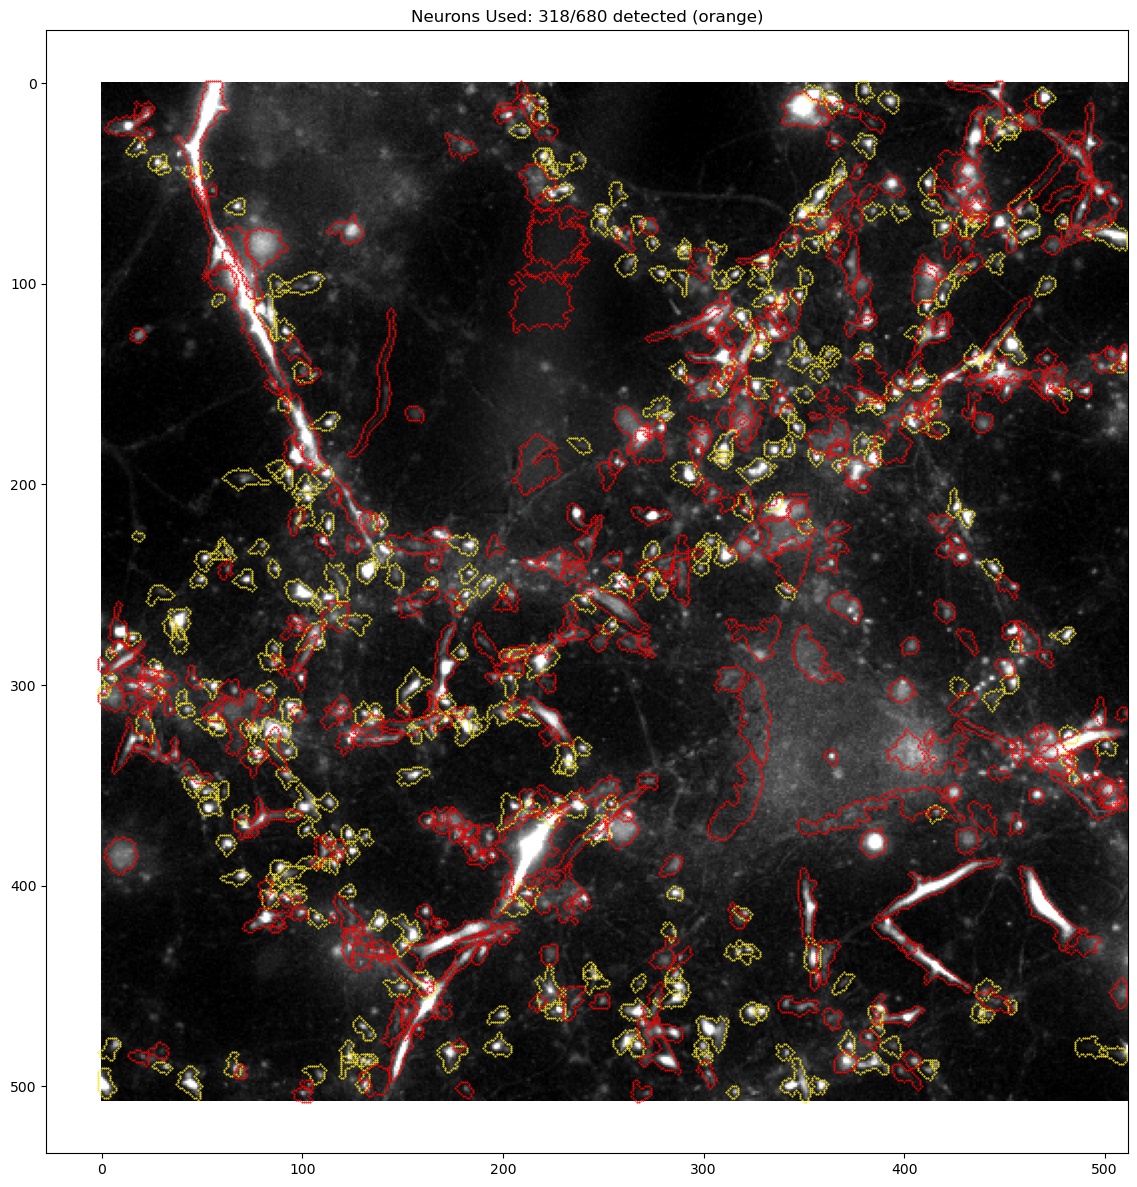

In [7]:
"""20 fps"""
show_fig_low_fps(r'C:\Users\jcbegs\Desktop\Lab_Business\AG_Dean\calcium_imaging\suite2p_tiff\frame_rate_test_new\20fps\suite2p\plane0')
print("Frame Rate: 20Hz")

Num cells: 855
Min/max skew:  -20000 20000
Neurons count: 332
Frame Rate: 40hz


NameError: name 'pixel2neuron' is not defined

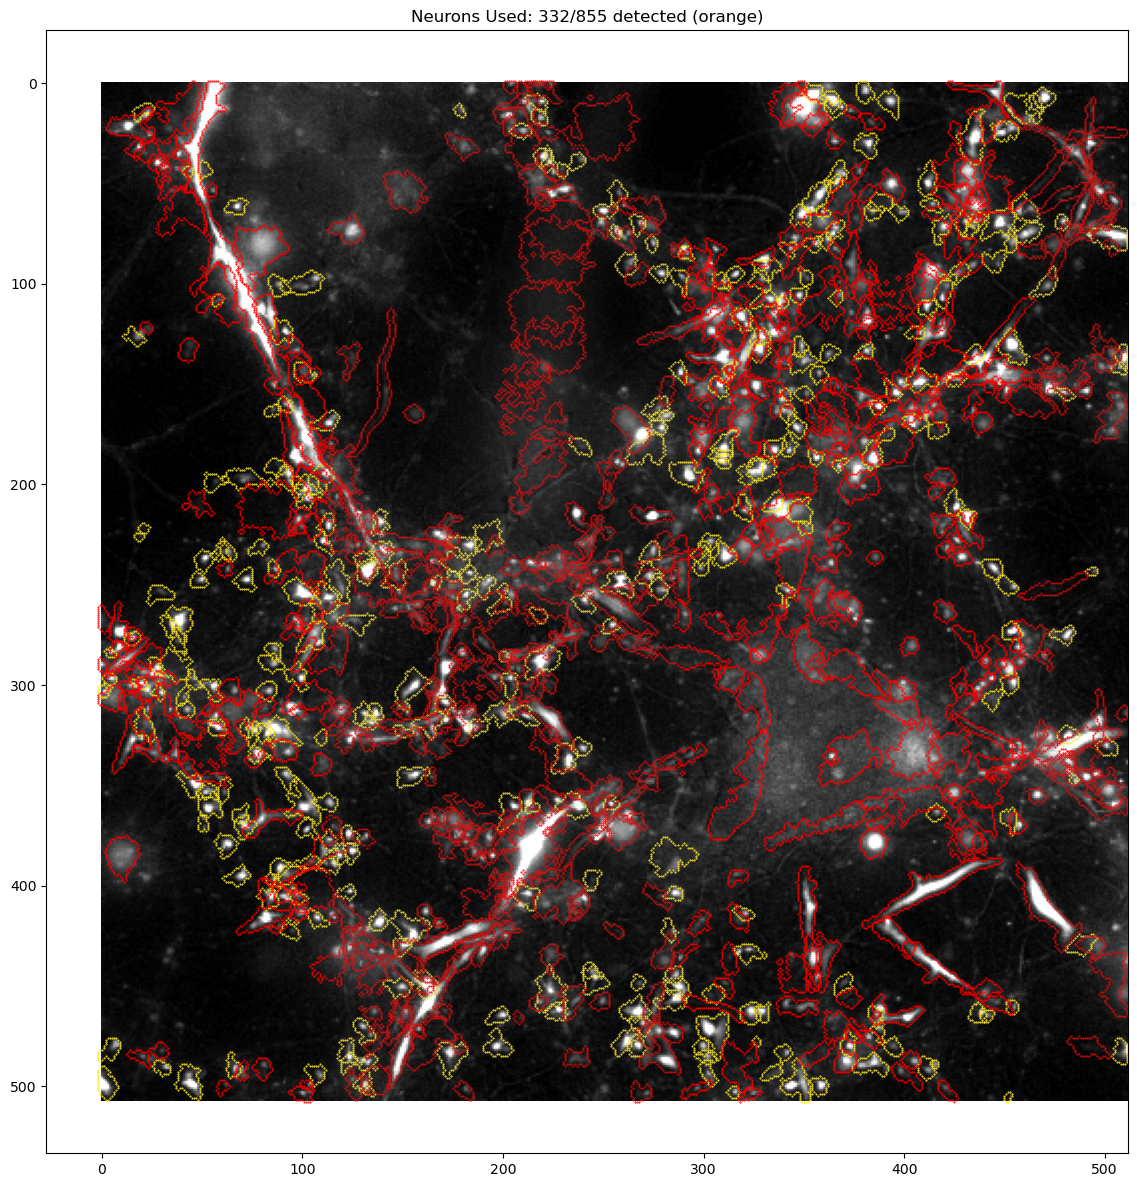

In [8]:
"""40fps"""
show_fig_low_fps(r'C:\Users\jcbegs\Desktop\Lab_Business\AG_Dean\calcium_imaging\suite2p_tiff\frame_rate_test_new\40fps\suite2p\plane0')
print("Frame Rate: 40hz")
print(pixel2neuron.shape)

In [ ]:
def create_grid():
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(12,5)
    gs=fig.add_gridspec(2,10)
    ax_img = fig.add_subplot(gs[:,6:])
    ax_raster = fig.add_subplot(gs[0,:3])
    ax_latency = fig.add_subplot(gs[1,:3])
    ax_freq = fig.add_subplot(gs[0,3:6])
    ax_amp = fig.add_subplot(gs[1,3:6])
    return fig, (ax_img, ax_raster, ax_amp, ax_freq, ax_latency)

max_img = getMaxImg(ops)
dispPlot(max_img, scatters, nid2idx, nid2idx_rejected, pixel2neuron, F, Fneu axs = ax_img)

In [ ]:
def plot_composite_fov(footprints, colormap='gist_rainbow', ax = None,label_idx=[],label='milk',highlight=False):
    '''
    Plots all footprints on a single composite field of view.
   
    Args:
        footprints (array):
            n_cells x rows x columns array of footprints
        colormap (str, optional)
            Colormap to use. Each cell will be assigned a random color from this map (defaults to 'gist_rainbow').
    Returns:
        tuple of fig, ax
            fig = matplotlib figure handle
            ax = matplotlib axis handle
    '''
   
    # fig, ax = plt.subplots(figsize=(6,6))
   
    # start with an array of zeros
    composite_fov = np.zeros((footprints.shape[1], footprints.shape[2], 3))
    cmap_vals = cm.get_cmap(colormap)
   
    np.random.seed(0)

    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())

        if cell_id not in label_idx:
          # only label red channel
        #   for color_channel in range(3):
        #     if color_channel == 0:
        #       composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        #     else:
        #       composite_fov[:,:,color_channel] -= color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        # else:
          # assign the color to each of the three channels, normalized by the footprint peak
            for color_channel in range(3):
                  composite_fov[:,:,color_channel] += color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
        # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1
    composite_fov[np.where(composite_fov > 0)] = 0.25 # make it half bright

    ## Do it again but make the label ROI to black (0) first before plotting
    for cell_id in range(footprints.shape[0]):
        # select a random color for this cell
        color = cmap_vals(np.random.rand())
        if not highlight:
            if cell_id in label_idx:
              # make ROI background as a negative value so the overlapping parts with other neurons are not getting weird
              for color_channel in range(3):
                composite_fov[:,:,color_channel] -=color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
                composite_fov[np.where(composite_fov < 0)] = 0 # make negative value to 0
            for color_channel in range(3):
                if color_channel in [0]:
                    composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000 # make it to extreme value so it's >0.25
                if color_channel in [1]:
                    composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000
        else:
            if cell_id in label_idx:
              # make ROI background as a negative value so the overlapping parts with other neurons are not getting weird
              for color_channel in range(3):
                composite_fov[:,:,color_channel] -=color[color_channel]*footprints[cell_id]/np.max(footprints[cell_id])
                composite_fov[np.where(composite_fov < 0)] = 0 # make negative value to 0
                for color_channel in range(3):
                    if color_channel in [1]:
                        composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000 # make it to extreme value so it's >0.25
                    if color_channel in [2]:
                        composite_fov[:,:,color_channel] += color[color_channel]*(footprints[cell_id]/np.max(footprints[cell_id])>0)*10000

    # set all values > 1 (where cells overlap) to 1:
    composite_fov[np.where(composite_fov > 1)] = 1
    # set all milk neurons ROIs to 1
    composite_fov[np.where(composite_fov > 0.25)] = 1
   
    # show the image
    ax.imshow(composite_fov)
    ax.text(x=footprints.shape[2]*0.97,y=5,s='all neurons n={}'.format(footprints.shape[0]),color='grey',ha='right',va='top',size=16)
    if not highlight:
        ax.text(x=footprints.shape[2]*0.97,y=13,s='{} n={}'.format(label,len(label_idx)),color='yellow',ha='right',va='top',size=16)
    else:
        ax.text(x=footprints.shape[2]*0.97,y=13,s='{} n={}'.format(label,len(label_idx)),color='cyan',ha='right',va='top',size=16)

    fig.tight_layout()
    return ax